## Configuration

In [ ]:
TRAIN_PATH = 'data/ebay/Tagged_Titles_Train.tsv'
LIST_PATH = 'data/ebay/Listing_Titles.tsv'

SAVE_DIRECTORY = "./saved_models"
EPOCHS = 100
BATCH_SIZE = 64
FINE_TUNE_BERT = False # set to true to train BERT as well
LR = 2e-5 if FINE_TUNE_BERT else 5e-4
MODEL_NAME = "GottBERT/GottBERT_base_last"


## Initialization

In [18]:
import csv 
import pandas as pd
import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, AutoConfig
import matplotlib.pyplot as plt
import seaborn as sns
import traceback 
import numpy as np
import os
from tqdm import tqdm
# Load model directly
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE=device
print(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
tokenizer = tokenizer

tagged_train = pd.read_csv(TRAIN_PATH, sep='\t')
os.makedirs(SAVE_DIRECTORY, exist_ok=True)




cuda


Loading weights: 100%|██████████| 199/199 [00:01<00:00, 183.13it/s, Materializing param=pooler.dense.weight]                               
RobertaModel LOAD REPORT from: GottBERT/GottBERT_base_last
Key                       | Status     |  | 
--------------------------+------------+--+-
lm_head.layer_norm.weight | UNEXPECTED |  | 
lm_head.dense.weight      | UNEXPECTED |  | 
lm_head.bias              | UNEXPECTED |  | 
lm_head.decoder.bias      | UNEXPECTED |  | 
lm_head.layer_norm.bias   | UNEXPECTED |  | 
lm_head.dense.bias        | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


## MLP Classifier Architecture 

In [19]:
import torch
import torch.nn as nn

class MLPClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dims=[64, 256, 128], num_classes=59, dropout=0.3):
        """
        Args:
            input_dim (int): Size of input features.
            hidden_dims (list): List of hidden layer sizes. Pass [] for a single linear layer.
            num_classes (int): Number of output classes.
            dropout (float): Dropout probability.
        """
        super().__init__()
        layers = []
        current_dim = input_dim

        # Dynamically create hidden layers
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            layers.append(nn.LayerNorm(h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            current_dim = h_dim

        # Final output layer (Project to num_classes)
        layers.append(nn.Linear(current_dim, num_classes))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.model(x)
        return logits

In [20]:
def get_original_classes(df):
    tags = df['Tag'].fillna("").astype(str).str.strip()
    unique_tags = tags[tags != ''].unique()
    sorted_tags = sorted(unique_tags)
    print(f"--- Original Class Analysis ---")
    print(f"Total Unique Classes Found: {len(sorted_tags)}")
    print(f"Classes: {sorted_tags}")
    
    return sorted_tags

print("done")

done


## Preprocessing

In [21]:
from torch.utils.data import Dataset

def preprocess_ebay_ner_data(df):
    df['Tag'] = df['Tag'].fillna('')
    all_raw_tags = df['Tag'].astype(str).str.strip().unique()
    unique_aspects = set()
    
    for tag in all_raw_tags:
        if tag not in ['', 'O', '0', 'nan']:
            unique_aspects.add(tag)
            
    # 3. Construct the full label set (O + B-Tag + I-Tag for every aspect)
    # This ensures 59 classes (1 'O' + 29*2) if all 29 aspects are in the data.
    unique_labels = ['O']
    for aspect in sorted(list(unique_aspects)):
        unique_labels.append(f"B-{aspect}")
        unique_labels.append(f"I-{aspect}")
        
    # Create mappings
    # We sort again to ensure 'O' and the rest are in a deterministic order
    unique_labels = sorted(unique_labels)
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for i, label in enumerate(unique_labels)}

    print(f"Generated {len(unique_labels)} classes from data.")
    grouped_titles = []
    grouped_labels = []

    for record_id, group in df.groupby('Record Number'):
        tokens = group['Token'].astype(str).tolist()
        raw_tags = group['Tag'].tolist()
        bio_tags = []
        current_entity_tag = None
        for tag in raw_tags: 
            tag = tag.strip()
            if tag == 'O' or tag == '0': 
                bio_tags.append('O')
                current_entity_tag = None
            elif tag != '':
                bio_tags.append(f"B-{tag}")
                current_entity_tag = tag
            else:
                if current_entity_tag:
                    bio_tags.append(f"I-{current_entity_tag}")
                else:
                    bio_tags.append('O')

        grouped_titles.append(tokens)
        grouped_labels.append(bio_tags)
    # unique_labels = sorted(list(set([l for seq in grouped_labels for l in seq])))
    label2id = {label: i for i, label in enumerate(unique_labels)}
    id2label = {i: label for i, label in enumerate(unique_labels)}

    return grouped_titles, grouped_labels, label2id, id2label 


class BertDataset(Dataset):
    def __init__(self, token_lists, label_lists, label2id, max_len=128):
        self.token_lists = token_lists
        self.label_lists = label_lists
        self.label2id = label2id
        self.tokenizer = tokenizer
        self.max_len = max_len 

    def __len__(self):
        return len(self.token_lists)

    def __getitem__(self, idx):
        word_list = self.token_lists[idx]
        label_list = self.label_lists[idx]
        encoding = self.tokenizer(
            word_list,
            is_split_into_words=True,
            padding='max_length',
            truncation =True, 
            max_length=self.max_len,
            return_tensors='pt'
        )
        word_ids = encoding.word_ids(batch_index=0)
        encoded_labels= []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                encoded_labels.append(-100)
            elif word_idx != previous_word_idx:
                label_str = label_list[word_idx]
                encoded_labels.append(self.label2id[label_str])

            else: 
                encoded_labels.append(-100)
            
            previous_word_idx = word_idx 

        labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = labels_tensor

        return item





In [22]:
import pandas as pd
import csv
import os
from sklearn.model_selection import train_test_split

def load_and_prepare_data(train_csv_path, listing_csv_path=None):
    """
    Loads the eBay NER datasets with specific parameters to handle 
    tab-separation and empty 'continuation' tags correctly.
    
    Args:
        train_csv_path (str): Path to the tagged training data file.
        listing_csv_path (str, optional): Path to the listing titles file (if needed for context).
        
    Returns:
        tuple: (train_df, token_lists, label_lists, label2id, id2label)
    """
    print(f"Loading data from {train_csv_path}...")
    
    # 1. Load Training Data
    # source: [113-116] - Specific pandas settings required:
    # - sep="\t": Data is tab-separated
    # - keep_default_na=False: Prevent pandas from turning empty strings into NaN
    # - na_values=None: Ensure no other values are treated as NA
    # - quoting: The file uses CSV-style quoting 
    try:
        train_df = pd.read_csv(
            train_csv_path, 
            sep="\t", 
            keep_default_na=False, 
            na_values=None,
            quoting=csv.QUOTE_MINIMAL, # Handles standard CSV quoting used in the file
            encoding='utf-8'
        )
    except Exception as e:
        print(f"Error loading train data: {e}")
        return None

    # 2. Load Listing Data (Optional, context only)
    # The training file already contains tokens, but this can be useful for EDA.
    if listing_csv_path and os.path.exists(listing_csv_path):
        listing_df = pd.read_csv(
            listing_csv_path, 
            sep="\t", 
            keep_default_na=False, 
            na_values=None,
            encoding='utf-8'
        )
        print(f"Loaded {len(listing_df)} listing records.")
    
    print(f"Loaded {len(train_df)} training tokens.")

    # 3. Preprocess to BIO Format
    # Re-using the logic defined in previous steps
    print("Preprocessing data into BIO format...")
    labels = get_original_classes(train_df)
    token_lists, label_lists, label2id, id2label = preprocess_ebay_ner_data(train_df)
    
    print(f"Processed {len(token_lists)} sentences.")
    print(f"Found {len(label2id)} unique classes (including 'O' and B-/I- prefixes).")
    
    return train_df, token_lists, label_lists, label2id, id2label

In [23]:
train_df, grouped_titles, grouped_labels, label2id, id2label = load_and_prepare_data(TRAIN_PATH, LIST_PATH)

Loading data from data/ebay/Tagged_Titles_Train.tsv...
Loaded 56812 training tokens.
Preprocessing data into BIO format...
--- Original Class Analysis ---
Total Unique Classes Found: 30
Classes: ['Anwendung', 'Anzahl_Der_Einheiten', 'Besonderheiten', 'Breite', 'Bremsscheiben-Aussendurchmesser', 'Bremsscheibenart', 'Einbauposition', 'Farbe', 'Größe', 'Hersteller', 'Herstellernummer', 'Herstellungsland_Und_-Region', 'Im_Lieferumfang_Enthalten', 'Kompatible_Fahrzeug_Marke', 'Kompatibles_Fahrzeug_Jahr', 'Kompatibles_Fahrzeug_Modell', 'Länge', 'Material', 'Maßeinheit', 'Menge', 'Modell', 'O', 'Oberflächenbeschaffenheit', 'Oe/Oem_Referenznummer(N)', 'Produktart', 'Produktlinie', 'SAE_Viskosität', 'Stärke', 'Technologie', 'Zähnezahl']
Generated 59 classes from data.
Processed 5000 sentences.
Found 59 unique classes (including 'O' and B-/I- prefixes).


## Dataset Verification

In [24]:
total_dataset = BertDataset(token_lists = grouped_titles, label_lists = grouped_labels, label2id = label2id, max_len=128)
sample = total_dataset[1826]
print(sample)
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print(sample['input_ids'].shape)

{'input_ids': tensor([    0,   305,   524,   796,   124,   319, 51454, 34499, 19833,  2924,
        37141,   546, 19343, 43388,  5684,  2118,   166,   199,  2656,   166,
        39988,   951,   219,   951,   380,   728,   380,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

In [25]:
example = "MINI 1.6 W10B16A W11B16A R50 Steuerkettensatz 11311485400 Steuerkette FEBI 31803"

In [26]:
tokens = tokenizer(example.split(" "), return_tensors="pt", padding=True, is_split_into_words=True)
tokens = tokens.to(DEVICE)
print(tokens.word_ids())
print(tokenizer.convert_ids_to_tokens(tokens["input_ids"][0]))
with torch.no_grad():
    outs = model(**tokens)

print(outs.last_hidden_state.shape)
classifier = MLPClassifier(input_dim=768, hidden_dims=[64], num_classes=59).to(DEVICE)
preds = classifier(outs.last_hidden_state)
print(preds.shape)

[None, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 8, 8, 9, 9, 9, None]
['<s>', 'M', 'IN', 'I', '1', '.', '6', 'W', '10', 'B', '16', 'A', 'W', '11', 'B', '16', 'A', 'R', '50', 'Steuer', 'ketten', 'satz', '113', '11', '48', '54', '00', 'Steuer', 'kette', 'FE', 'BI', '3', '18', '03', '</s>']
torch.Size([1, 35, 768])
torch.Size([1, 35, 59])


## Training Functions

In [27]:
import traceback
def validate(bert_model, classifier, dataloader, device, id2label):
    bert_model.eval()
    classifier.eval()

    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = bert_model(input_ids, attention_mask=attention_masks)
            logits = classifier(outputs.last_hidden_state)
            loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
            running_loss += loss.item()
            preds = torch.argmax(logits, dim=2)
            mask = labels != -100 
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    unique_labels = sorted(list(set(all_labels)))
    target_names = [id2label[i] for i in unique_labels]
    report_dict = classification_report(
        all_labels,
        all_preds, 
        labels=unique_labels,
        target_names=target_names,
        output_dict=True,
        zero_division=0
    )
    report_str = classification_report(
        all_labels,
        all_preds, 
        labels=unique_labels,
        target_names=target_names,
        zero_division=0
    )
    return avg_loss, report_dict, report_str

def plot_results(train_loss_history, val_loss_history, final_report, epochs):
    """
    Plots training vs validation loss and per-class F1 scores.
    """
    plt.figure(figsize=(16, 6))

    # Plot 1: Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss', color='#1f77b4', linewidth=2)
    
    # We plot val loss as points or a line corresponding to epochs
    # Since val_loss is recorded once per epoch, we stretch it or plot it against epoch indices
    # Here we just plot the sequence of validation losses
    plt.plot(np.linspace(0, len(train_loss_history), len(val_loss_history)), 
             val_loss_history, label='Val Loss', color='#d62728', marker='o', linewidth=2)
    
    plt.title(f"Loss Curve over {epochs} Epochs")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Top 20 Class F1 Scores
    plt.subplot(1, 2, 2)
    class_metrics = {k: v['f1-score'] for k, v in final_report.items() 
                     if isinstance(v, dict) and k not in ['accuracy', 'macro avg', 'weighted avg']}
    
    # Sort and slice top 20
    sorted_classes = sorted(class_metrics.items(), key=lambda x: x[1], reverse=True)
    names = [x[0] for x in sorted_classes]
    scores = [x[1] for x in sorted_classes]
    
    sns.barplot(x=scores, y=names, palette='viridis', hue=names, legend=False)
    plt.title(f"Top F1 Scores (Epoch {epochs})")
    plt.xlabel("F1 Score")
    plt.xlim(0, 1.0)
    plt.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

def train_model(bert_model, classifier, train_loader, val_loader, label2id, id2label):
    print(f"Initializing Models... (Fine-tune Bert: {FINE_TUNE_BERT})")
    for param in bert_model.parameters():
        param.requires_grad = FINE_TUNE_BERT
    
    params_to_optimize = list(classifier.parameters())
    if FINE_TUNE_BERT:
        params_to_optimize += list(bert_model.parameters())
    optimizer = torch.optim.AdamW(params_to_optimize, lr=LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index = -100)

    train_loss_history = []
    val_loss_history = []
    final_val_report = {}
    try:
        print(f"Starting Training for {EPOCHS} Epochs... ")
        for epoch in range(EPOCHS):
            bert_model.train()
            classifier.train()
            running_train_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f"EPOCH {epoch + 1}/ {EPOCHS}")
            for batch in progress_bar: 
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)
                
                optimizer.zero_grad()
                
                # Forward Pass
                outputs = bert_model(input_ids, attention_mask=attention_mask)
                logits = classifier(outputs.last_hidden_state)
                
                # Loss
                loss = loss_fn(logits.view(-1, len(label2id)), labels.view(-1))
                
                # Backward
                loss.backward()
                optimizer.step()
                
                # Track Loss
                running_train_loss += loss.item()
                train_loss_history.append(loss.item())
                
                # Update Progress Bar
                progress_bar.set_postfix({'loss': loss.item()})
            print(f"Validating Epoch {epoch+1}... ")
            val_loss, val_report, val_report_str = validate(bert_model, classifier, val_loader, DEVICE, id2label)
            val_loss_history.append(val_loss)
            final_val_report = val_report

            print(f"Epoch {epoch+1} Summary | Train Loss: {running_train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")
            print(val_report_str)
    except Exception as e:
        raise

    finally:
        torch.save(bert_model.state_dict(), os.path.join(SAVE_DIRECTORY, "bert_model.pth"))
        torch.save(classifier.state_dict(), os.path.join(SAVE_DIRECTORY, "classifier_head.pth"))
        plot_results(train_loss_history, val_loss_history, final_val_report, EPOCHS)
    
    return bert_model, classifier, train_loss_history, val_loss_history, final_val_report



## Training Loop

Initializing Models... (Fine-tune Bert: False)
Starting Training for 100 Epochs... 


EPOCH 1/ 100: 100%|██████████| 71/71 [00:29<00:00,  2.38it/s, loss=2.98]


Validating Epoch 1... 
Epoch 1 Summary | Train Loss: 3.4558 | Val Loss: 2.8197
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.00      0.00      0.00       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.92      0.39      0.55       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.83      0.01      0.03       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.55      0.80      0.65       649
      B-Kompatible_Fahrzeug_Marke       0.64      0.64      0.64       697
      B-Kompatibles_

EPOCH 2/ 100: 100%|██████████| 71/71 [00:29<00:00,  2.39it/s, loss=2.43]


Validating Epoch 2... 
Epoch 2 Summary | Train Loss: 2.6722 | Val Loss: 2.2887
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       1.00      0.03      0.05       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.93      0.75      0.83       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.22      0.36       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.68      0.90      0.78       649
      B-Kompatible_Fahrzeug_Marke       0.66      0.82      0.73       697
      B-Kompatibles_

EPOCH 3/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.35it/s, loss=2.04]


Validating Epoch 3... 
Epoch 3 Summary | Train Loss: 2.2586 | Val Loss: 1.9271
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.96      0.35      0.51       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.82      0.86       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.41      0.57       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.71      0.91      0.80       649
      B-Kompatible_Fahrzeug_Marke       0.69      0.89      0.78       697
      B-Kompatibles_

EPOCH 4/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.36it/s, loss=1.81]


Validating Epoch 4... 
Epoch 4 Summary | Train Loss: 1.9600 | Val Loss: 1.6693
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.89      0.52      0.66       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.92      0.88      0.90       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.56      0.70       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.74      0.92      0.82       649
      B-Kompatible_Fahrzeug_Marke       0.72      0.92      0.81       697
      B-Kompatibles_

EPOCH 5/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.35it/s, loss=1.7] 


Validating Epoch 5... 
Epoch 5 Summary | Train Loss: 1.7423 | Val Loss: 1.4700
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.84      0.69      0.76       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.93      0.92       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.68      0.79       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.75      0.92      0.83       649
      B-Kompatible_Fahrzeug_Marke       0.75      0.93      0.83       697
      B-Kompatibles_

EPOCH 6/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.35it/s, loss=1.44]


Validating Epoch 6... 
Epoch 6 Summary | Train Loss: 1.5730 | Val Loss: 1.3159
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.81      0.82       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.95      0.93       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.75      0.83       387
               B-Herstellernummer       0.00      0.00      0.00       134
      B-Im_Lieferumfang_Enthalten       0.76      0.92      0.83       649
      B-Kompatible_Fahrzeug_Marke       0.77      0.94      0.85       697
      B-Kompatibles_

EPOCH 7/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.36it/s, loss=1.34]


Validating Epoch 7... 
Epoch 7 Summary | Train Loss: 1.4388 | Val Loss: 1.1902
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.00      0.00      0.00        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.86      0.84       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.96      0.93       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.92      0.79      0.85       387
               B-Herstellernummer       1.00      0.01      0.03       134
      B-Im_Lieferumfang_Enthalten       0.76      0.93      0.84       649
      B-Kompatible_Fahrzeug_Marke       0.80      0.94      0.87       697
      B-Kompatibles_

EPOCH 8/ 100: 100%|██████████| 71/71 [00:29<00:00,  2.37it/s, loss=1.35]


Validating Epoch 8... 
Epoch 8 Summary | Train Loss: 1.3320 | Val Loss: 1.0928
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.10      0.18        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.82      0.90      0.86       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.97      0.94       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.92      0.82      0.87       387
               B-Herstellernummer       0.88      0.10      0.19       134
      B-Im_Lieferumfang_Enthalten       0.77      0.93      0.84       649
      B-Kompatible_Fahrzeug_Marke       0.82      0.95      0.88       697
      B-Kompatibles_

EPOCH 9/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, loss=1.34]


Validating Epoch 9... 
Epoch 9 Summary | Train Loss: 1.2437 | Val Loss: 1.0103
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.20      0.33        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.90      0.85       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.90      0.97      0.93       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.92      0.84      0.88       387
               B-Herstellernummer       0.89      0.23      0.37       134
      B-Im_Lieferumfang_Enthalten       0.77      0.93      0.84       649
      B-Kompatible_Fahrzeug_Marke       0.83      0.94      0.88       697
      B-Kompatibles_

EPOCH 10/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, loss=1.17] 


Validating Epoch 10... 
Epoch 10 Summary | Train Loss: 1.1678 | Val Loss: 0.9419
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.33      0.50        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.79      0.93      0.86       147
               B-Bremsscheibenart       0.00      0.00      0.00        41
                 B-Einbauposition       0.91      0.97      0.94       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.91      0.85      0.88       387
               B-Herstellernummer       0.87      0.36      0.51       134
      B-Im_Lieferumfang_Enthalten       0.78      0.93      0.84       649
      B-Kompatible_Fahrzeug_Marke       0.82      0.95      0.88       697
      B-Kompatible

EPOCH 11/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, loss=1.09]


Validating Epoch 11... 
Epoch 11 Summary | Train Loss: 1.1066 | Val Loss: 0.8847
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.40      0.57        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.93      0.86       147
               B-Bremsscheibenart       1.00      0.05      0.09        41
                 B-Einbauposition       0.91      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.86      0.89       387
               B-Herstellernummer       0.85      0.43      0.57       134
      B-Im_Lieferumfang_Enthalten       0.78      0.92      0.85       649
      B-Kompatible_Fahrzeug_Marke       0.85      0.94      0.90       697
      B-Kompatible

EPOCH 12/ 100: 100%|██████████| 71/71 [00:29<00:00,  2.40it/s, loss=1.02] 


Validating Epoch 12... 
Epoch 12 Summary | Train Loss: 1.0523 | Val Loss: 0.8354
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.40      0.57        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.96      0.87       147
               B-Bremsscheibenart       1.00      0.10      0.18        41
                 B-Einbauposition       0.91      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.92      0.87      0.90       387
               B-Herstellernummer       0.81      0.48      0.60       134
      B-Im_Lieferumfang_Enthalten       0.79      0.92      0.85       649
      B-Kompatible_Fahrzeug_Marke       0.85      0.94      0.89       697
      B-Kompatible

EPOCH 13/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.36it/s, loss=0.87] 


Validating Epoch 13... 
Epoch 13 Summary | Train Loss: 1.0066 | Val Loss: 0.7931
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.53      0.70        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.96      0.87       147
               B-Bremsscheibenart       1.00      0.20      0.33        41
                 B-Einbauposition       0.91      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.88      0.90       387
               B-Herstellernummer       0.84      0.58      0.69       134
      B-Im_Lieferumfang_Enthalten       0.79      0.93      0.86       649
      B-Kompatible_Fahrzeug_Marke       0.85      0.94      0.90       697
      B-Kompatible

EPOCH 14/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=1.11] 


Validating Epoch 14... 
Epoch 14 Summary | Train Loss: 0.9666 | Val Loss: 0.7564
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.63      0.78        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.97      0.87       147
               B-Bremsscheibenart       1.00      0.24      0.39        41
                 B-Einbauposition       0.91      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.92      0.89      0.91       387
               B-Herstellernummer       0.82      0.63      0.71       134
      B-Im_Lieferumfang_Enthalten       0.81      0.93      0.86       649
      B-Kompatible_Fahrzeug_Marke       0.86      0.95      0.90       697
      B-Kompatible

EPOCH 15/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.835]


Validating Epoch 15... 
Epoch 15 Summary | Train Loss: 0.9302 | Val Loss: 0.7255
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.67      0.80        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.97      0.88       147
               B-Bremsscheibenart       1.00      0.24      0.39        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.90      0.91       387
               B-Herstellernummer       0.85      0.67      0.75       134
      B-Im_Lieferumfang_Enthalten       0.81      0.93      0.86       649
      B-Kompatible_Fahrzeug_Marke       0.89      0.94      0.91       697
      B-Kompatible

EPOCH 16/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.933]


Validating Epoch 16... 
Epoch 16 Summary | Train Loss: 0.9021 | Val Loss: 0.7003
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.73      0.85        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.79      0.97      0.87       147
               B-Bremsscheibenart       1.00      0.27      0.42        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.90      0.92       387
               B-Herstellernummer       0.79      0.72      0.75       134
      B-Im_Lieferumfang_Enthalten       0.82      0.93      0.87       649
      B-Kompatible_Fahrzeug_Marke       0.89      0.94      0.92       697
      B-Kompatible

EPOCH 17/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.863]


Validating Epoch 17... 
Epoch 17 Summary | Train Loss: 0.8768 | Val Loss: 0.6748
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.80      0.89        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.97      0.88       147
               B-Bremsscheibenart       1.00      0.27      0.42        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.91      0.92       387
               B-Herstellernummer       0.86      0.75      0.80       134
      B-Im_Lieferumfang_Enthalten       0.82      0.93      0.87       649
      B-Kompatible_Fahrzeug_Marke       0.88      0.94      0.91       697
      B-Kompatible

EPOCH 18/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.833]


Validating Epoch 18... 
Epoch 18 Summary | Train Loss: 0.8477 | Val Loss: 0.6551
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.83      0.91        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.98      0.88       147
               B-Bremsscheibenart       1.00      0.29      0.45        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.92      0.92       387
               B-Herstellernummer       0.84      0.77      0.80       134
      B-Im_Lieferumfang_Enthalten       0.82      0.93      0.87       649
      B-Kompatible_Fahrzeug_Marke       0.89      0.95      0.92       697
      B-Kompatible

EPOCH 19/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.723]


Validating Epoch 19... 
Epoch 19 Summary | Train Loss: 0.8260 | Val Loss: 0.6346
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.83      0.91        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.98      0.88       147
               B-Bremsscheibenart       1.00      0.29      0.45        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.95      0.92      0.93       387
               B-Herstellernummer       0.83      0.78      0.80       134
      B-Im_Lieferumfang_Enthalten       0.84      0.93      0.88       649
      B-Kompatible_Fahrzeug_Marke       0.90      0.94      0.92       697
      B-Kompatible

EPOCH 20/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.694]


Validating Epoch 20... 
Epoch 20 Summary | Train Loss: 0.8077 | Val Loss: 0.6202
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.83      0.91        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.80      0.98      0.88       147
               B-Bremsscheibenart       1.00      0.29      0.45        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.93      0.93       387
               B-Herstellernummer       0.81      0.80      0.80       134
      B-Im_Lieferumfang_Enthalten       0.83      0.93      0.88       649
      B-Kompatible_Fahrzeug_Marke       0.90      0.94      0.92       697
      B-Kompatible

EPOCH 21/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.831]


Validating Epoch 21... 
Epoch 21 Summary | Train Loss: 0.7916 | Val Loss: 0.6045
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.87      0.93        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.29      0.45        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.93      0.93       387
               B-Herstellernummer       0.78      0.81      0.79       134
      B-Im_Lieferumfang_Enthalten       0.84      0.93      0.88       649
      B-Kompatible_Fahrzeug_Marke       0.89      0.95      0.92       697
      B-Kompatible

EPOCH 22/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.30it/s, loss=0.915]


Validating Epoch 22... 
Epoch 22 Summary | Train Loss: 0.7759 | Val Loss: 0.5895
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.87      0.93        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.82      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.98      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.93      0.93       387
               B-Herstellernummer       0.79      0.81      0.80       134
      B-Im_Lieferumfang_Enthalten       0.85      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.90      0.95      0.93       697
      B-Kompatible

EPOCH 23/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.30it/s, loss=0.735]


Validating Epoch 23... 
Epoch 23 Summary | Train Loss: 0.7639 | Val Loss: 0.5788
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.87      0.93        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.94      0.94       387
               B-Herstellernummer       0.78      0.81      0.79       134
      B-Im_Lieferumfang_Enthalten       0.85      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.90      0.95      0.93       697
      B-Kompatible

EPOCH 24/ 100: 100%|██████████| 71/71 [00:31<00:00,  2.29it/s, loss=0.776]


Validating Epoch 24... 
Epoch 24 Summary | Train Loss: 0.7497 | Val Loss: 0.5660
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.87      0.93        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.94      0.94       387
               B-Herstellernummer       0.82      0.81      0.81       134
      B-Im_Lieferumfang_Enthalten       0.85      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.91      0.94      0.93       697
      B-Kompatible

EPOCH 25/ 100: 100%|██████████| 71/71 [00:31<00:00,  2.29it/s, loss=0.618]


Validating Epoch 25... 
Epoch 25 Summary | Train Loss: 0.7393 | Val Loss: 0.5573
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.90      0.95        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.94      0.94      0.94       387
               B-Herstellernummer       0.81      0.81      0.81       134
      B-Im_Lieferumfang_Enthalten       0.86      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.91      0.95      0.93       697
      B-Kompatible

EPOCH 26/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.30it/s, loss=0.707]


Validating Epoch 26... 
Epoch 26 Summary | Train Loss: 0.7246 | Val Loss: 0.5479
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.90      0.95        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.82      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.94      0.95       387
               B-Herstellernummer       0.78      0.83      0.80       134
      B-Im_Lieferumfang_Enthalten       0.86      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.91      0.95      0.93       697
      B-Kompatible

EPOCH 27/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.647]


Validating Epoch 27... 
Epoch 27 Summary | Train Loss: 0.7126 | Val Loss: 0.5389
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.90      0.95        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       1.00      0.32      0.48        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.93      0.94      0.94       387
               B-Herstellernummer       0.84      0.82      0.83       134
      B-Im_Lieferumfang_Enthalten       0.86      0.93      0.90       649
      B-Kompatible_Fahrzeug_Marke       0.91      0.95      0.93       697
      B-Kompatible

EPOCH 28/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, loss=0.662]


Validating Epoch 28... 
Epoch 28 Summary | Train Loss: 0.7056 | Val Loss: 0.5309
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.90      0.95        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       1.00      0.37      0.54        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.95      0.94      0.94       387
               B-Herstellernummer       0.81      0.83      0.82       134
      B-Im_Lieferumfang_Enthalten       0.86      0.93      0.90       649
      B-Kompatible_Fahrzeug_Marke       0.92      0.95      0.94       697
      B-Kompatible

EPOCH 29/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.66] 


Validating Epoch 29... 
Epoch 29 Summary | Train Loss: 0.6923 | Val Loss: 0.5230
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.90      0.95        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       1.00      0.41      0.59        41
                 B-Einbauposition       0.92      0.99      0.95       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.95      0.94      0.95       387
               B-Herstellernummer       0.85      0.83      0.84       134
      B-Im_Lieferumfang_Enthalten       0.86      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.95      0.94       697
      B-Kompatible

EPOCH 30/ 100: 100%|██████████| 71/71 [00:41<00:00,  1.72it/s, loss=0.821]


Validating Epoch 30... 
Epoch 30 Summary | Train Loss: 0.6932 | Val Loss: 0.5202
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       1.00      0.46      0.63        41
                 B-Einbauposition       0.92      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.95      0.95      0.95       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.85      0.93      0.89       649
      B-Kompatible_Fahrzeug_Marke       0.91      0.96      0.93       697
      B-Kompatible

EPOCH 31/ 100: 100%|██████████| 71/71 [00:42<00:00,  1.66it/s, loss=0.43] 


Validating Epoch 31... 
Epoch 31 Summary | Train Loss: 0.6830 | Val Loss: 0.5096
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       0.96      0.56      0.71        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.94      0.95       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.87      0.93      0.90       649
      B-Kompatible_Fahrzeug_Marke       0.92      0.95      0.94       697
      B-Kompatible

EPOCH 32/ 100: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s, loss=0.703]


Validating Epoch 32... 
Epoch 32 Summary | Train Loss: 0.6751 | Val Loss: 0.5057
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       0.93      0.66      0.77        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.95      0.94      0.95       387
               B-Herstellernummer       0.83      0.84      0.83       134
      B-Im_Lieferumfang_Enthalten       0.87      0.94      0.90       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.95      0.94       697
      B-Kompatible

EPOCH 33/ 100: 100%|██████████| 71/71 [00:42<00:00,  1.68it/s, loss=0.704]


Validating Epoch 33... 
Epoch 33 Summary | Train Loss: 0.6679 | Val Loss: 0.4987
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       0.96      0.63      0.76        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.94      0.95       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.87      0.94      0.90       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.95      0.94       697
      B-Kompatible

EPOCH 34/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.34it/s, loss=0.649]


Validating Epoch 34... 
Epoch 34 Summary | Train Loss: 0.6639 | Val Loss: 0.4952
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.81      0.98      0.89       147
               B-Bremsscheibenart       0.97      0.71      0.82        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.94      0.95       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.88      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.95      0.94       697
      B-Kompatible

EPOCH 35/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.822]


Validating Epoch 35... 
Epoch 35 Summary | Train Loss: 0.6529 | Val Loss: 0.4896
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.97      0.91       147
               B-Bremsscheibenart       0.97      0.71      0.82        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.95       387
               B-Herstellernummer       0.85      0.83      0.84       134
      B-Im_Lieferumfang_Enthalten       0.88      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.94       697
      B-Kompatible

EPOCH 36/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.812]


Validating Epoch 36... 
Epoch 36 Summary | Train Loss: 0.6488 | Val Loss: 0.4873
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.84      0.97      0.90       147
               B-Bremsscheibenart       0.94      0.71      0.81        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.88      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.92      0.96      0.94       697
      B-Kompatible

EPOCH 37/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.635]


Validating Epoch 37... 
Epoch 37 Summary | Train Loss: 0.6432 | Val Loss: 0.4822
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.82      0.98      0.89       147
               B-Bremsscheibenart       0.97      0.71      0.82        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.94       697
      B-Kompatible

EPOCH 38/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.606]


Validating Epoch 38... 
Epoch 38 Summary | Train Loss: 0.6349 | Val Loss: 0.4799
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       0.97      0.71      0.82        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.92      0.97      0.94       697
      B-Kompatible

EPOCH 39/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.564]


Validating Epoch 39... 
Epoch 39 Summary | Train Loss: 0.6319 | Val Loss: 0.4769
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.92      0.96      0.94       697
      B-Kompatible

EPOCH 40/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.557]


Validating Epoch 40... 
Epoch 40 Summary | Train Loss: 0.6319 | Val Loss: 0.4701
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.80      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.94      0.95       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.91       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.95       697
      B-Kompatible

EPOCH 41/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.644]


Validating Epoch 41... 
Epoch 41 Summary | Train Loss: 0.6187 | Val Loss: 0.4674
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.83      0.98      0.90       147
               B-Bremsscheibenart       0.97      0.80      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.94      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.95      0.94       697
      B-Kompatible

EPOCH 42/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.81] 


Validating Epoch 42... 
Epoch 42 Summary | Train Loss: 0.6230 | Val Loss: 0.4652
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.84      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.78      0.86        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.93      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.94       697
      B-Kompatible

EPOCH 43/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.497]


Validating Epoch 43... 
Epoch 43 Summary | Train Loss: 0.6126 | Val Loss: 0.4637
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.97      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.97      0.95       697
      B-Kompatible

EPOCH 44/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.665]


Validating Epoch 44... 
Epoch 44 Summary | Train Loss: 0.6120 | Val Loss: 0.4598
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.97      0.95       697
      B-Kompatible

EPOCH 45/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.71] 


Validating Epoch 45... 
Epoch 45 Summary | Train Loss: 0.6083 | Val Loss: 0.4583
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.80      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.95       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.94       697
      B-Kompatible

EPOCH 46/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.632]


Validating Epoch 46... 
Epoch 46 Summary | Train Loss: 0.6060 | Val Loss: 0.4594
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.95       697
      B-Kompatible

EPOCH 47/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.478]


Validating Epoch 47... 
Epoch 47 Summary | Train Loss: 0.6032 | Val Loss: 0.4536
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.96      0.95       697
      B-Kompatible

EPOCH 48/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.589]


Validating Epoch 48... 
Epoch 48 Summary | Train Loss: 0.5971 | Val Loss: 0.4510
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.87      0.84      0.86       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 49/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.609]


Validating Epoch 49... 
Epoch 49 Summary | Train Loss: 0.5985 | Val Loss: 0.4495
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 50/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.615]


Validating Epoch 50... 
Epoch 50 Summary | Train Loss: 0.5905 | Val Loss: 0.4452
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 51/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.654]


Validating Epoch 51... 
Epoch 51 Summary | Train Loss: 0.5906 | Val Loss: 0.4445
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 52/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.33it/s, loss=0.519]


Validating Epoch 52... 
Epoch 52 Summary | Train Loss: 0.5815 | Val Loss: 0.4425
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.89      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 53/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.66] 


Validating Epoch 53... 
Epoch 53 Summary | Train Loss: 0.5811 | Val Loss: 0.4402
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 54/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.506]


Validating Epoch 54... 
Epoch 54 Summary | Train Loss: 0.5789 | Val Loss: 0.4392
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.97      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.96      0.95       697
      B-Kompatible

EPOCH 55/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.548]


Validating Epoch 55... 
Epoch 55 Summary | Train Loss: 0.5788 | Val Loss: 0.4404
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.97      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 56/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.597]


Validating Epoch 56... 
Epoch 56 Summary | Train Loss: 0.5771 | Val Loss: 0.4379
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.97      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.93      0.97      0.95       697
      B-Kompatible

EPOCH 57/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.594]


Validating Epoch 57... 
Epoch 57 Summary | Train Loss: 0.5773 | Val Loss: 0.4348
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 58/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.439]


Validating Epoch 58... 
Epoch 58 Summary | Train Loss: 0.5714 | Val Loss: 0.4352
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.96      0.95       697
      B-Kompatible

EPOCH 59/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.622]


Validating Epoch 59... 
Epoch 59 Summary | Train Loss: 0.5697 | Val Loss: 0.4325
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 60/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.828]


Validating Epoch 60... 
Epoch 60 Summary | Train Loss: 0.5716 | Val Loss: 0.4308
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.93      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 61/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.588]


Validating Epoch 61... 
Epoch 61 Summary | Train Loss: 0.5658 | Val Loss: 0.4306
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.96      0.96      0.96       387
               B-Herstellernummer       0.83      0.84      0.83       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 62/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.592]


Validating Epoch 62... 
Epoch 62 Summary | Train Loss: 0.5660 | Val Loss: 0.4291
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 63/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.599]


Validating Epoch 63... 
Epoch 63 Summary | Train Loss: 0.5614 | Val Loss: 0.4289
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 64/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.442]


Validating Epoch 64... 
Epoch 64 Summary | Train Loss: 0.5634 | Val Loss: 0.4254
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.98      0.93       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.96      0.96       697
      B-Kompatible

EPOCH 65/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.723]


Validating Epoch 65... 
Epoch 65 Summary | Train Loss: 0.5634 | Val Loss: 0.4239
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.98      0.93       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 66/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.541]


Validating Epoch 66... 
Epoch 66 Summary | Train Loss: 0.5580 | Val Loss: 0.4254
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.96       697
      B-Kompatible

EPOCH 67/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.403]


Validating Epoch 67... 
Epoch 67 Summary | Train Loss: 0.5542 | Val Loss: 0.4220
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 68/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.477]


Validating Epoch 68... 
Epoch 68 Summary | Train Loss: 0.5552 | Val Loss: 0.4240
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.96      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.96       697
      B-Kompatible

EPOCH 69/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.487]


Validating Epoch 69... 
Epoch 69 Summary | Train Loss: 0.5525 | Val Loss: 0.4238
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.96       697
      B-Kompatible

EPOCH 70/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.396]


Validating Epoch 70... 
Epoch 70 Summary | Train Loss: 0.5496 | Val Loss: 0.4208
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 71/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.81] 


Validating Epoch 71... 
Epoch 71 Summary | Train Loss: 0.5504 | Val Loss: 0.4193
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 72/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.428]


Validating Epoch 72... 
Epoch 72 Summary | Train Loss: 0.5478 | Val Loss: 0.4202
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 73/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.442]


Validating Epoch 73... 
Epoch 73 Summary | Train Loss: 0.5449 | Val Loss: 0.4181
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 74/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.581]


Validating Epoch 74... 
Epoch 74 Summary | Train Loss: 0.5467 | Val Loss: 0.4193
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.92       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.83      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 75/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.63] 


Validating Epoch 75... 
Epoch 75 Summary | Train Loss: 0.5463 | Val Loss: 0.4151
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 76/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.471]


Validating Epoch 76... 
Epoch 76 Summary | Train Loss: 0.5450 | Val Loss: 0.4176
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.84      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 77/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.443]


Validating Epoch 77... 
Epoch 77 Summary | Train Loss: 0.5451 | Val Loss: 0.4163
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.89      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 78/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.44] 


Validating Epoch 78... 
Epoch 78 Summary | Train Loss: 0.5349 | Val Loss: 0.4162
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.84      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.95       697
      B-Kompatible

EPOCH 79/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.485]


Validating Epoch 79... 
Epoch 79 Summary | Train Loss: 0.5395 | Val Loss: 0.4132
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.92       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 80/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.646]


Validating Epoch 80... 
Epoch 80 Summary | Train Loss: 0.5378 | Val Loss: 0.4143
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.86      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 81/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.587]


Validating Epoch 81... 
Epoch 81 Summary | Train Loss: 0.5412 | Val Loss: 0.4132
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       0.00      0.00      0.00         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 82/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.501]


Validating Epoch 82... 
Epoch 82 Summary | Train Loss: 0.5353 | Val Loss: 0.4098
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.97      0.96      0.96       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 83/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.438]


Validating Epoch 83... 
Epoch 83 Summary | Train Loss: 0.5365 | Val Loss: 0.4101
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 84/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.507]


Validating Epoch 84... 
Epoch 84 Summary | Train Loss: 0.5326 | Val Loss: 0.4102
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.93      0.90       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.86      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.92      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.96       697
      B-Kompatible

EPOCH 85/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.668]


Validating Epoch 85... 
Epoch 85 Summary | Train Loss: 0.5377 | Val Loss: 0.4104
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 86/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.404]


Validating Epoch 86... 
Epoch 86 Summary | Train Loss: 0.5334 | Val Loss: 0.4104
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.84      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.86      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.94      0.97      0.96       697
      B-Kompatible

EPOCH 87/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.511]


Validating Epoch 87... 
Epoch 87 Summary | Train Loss: 0.5375 | Val Loss: 0.4088
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.94      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.83      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 88/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.436]


Validating Epoch 88... 
Epoch 88 Summary | Train Loss: 0.5279 | Val Loss: 0.4056
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.84      0.86      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 89/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.449]


Validating Epoch 89... 
Epoch 89 Summary | Train Loss: 0.5297 | Val Loss: 0.4086
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.98      0.93       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 90/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.741]


Validating Epoch 90... 
Epoch 90 Summary | Train Loss: 0.5302 | Val Loss: 0.4071
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.94      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.85      0.84      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.97      0.96       697
      B-Kompatible

EPOCH 91/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.471]


Validating Epoch 91... 
Epoch 91 Summary | Train Loss: 0.5272 | Val Loss: 0.4049
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.98      0.91       147
               B-Bremsscheibenart       0.97      0.83      0.89        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 92/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.781]


Validating Epoch 92... 
Epoch 92 Summary | Train Loss: 0.5321 | Val Loss: 0.4053
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.86      0.99      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 93/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.612]


Validating Epoch 93... 
Epoch 93 Summary | Train Loss: 0.5305 | Val Loss: 0.4042
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.98      0.93       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.83      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 94/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.30it/s, loss=0.528]


Validating Epoch 94... 
Epoch 94 Summary | Train Loss: 0.5226 | Val Loss: 0.4027
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.98      0.92       147
               B-Bremsscheibenart       0.94      0.83      0.88        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.84      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.97      0.96       697
      B-Kompatible

EPOCH 95/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.403]


Validating Epoch 95... 
Epoch 95 Summary | Train Loss: 0.5265 | Val Loss: 0.4023
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.97      0.97      0.97        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.99      0.91       147
               B-Bremsscheibenart       0.89      0.83      0.86        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.83      0.85      0.84       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.97      0.96       697
      B-Kompatible

EPOCH 96/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.32it/s, loss=0.579]


Validating Epoch 96... 
Epoch 96 Summary | Train Loss: 0.5225 | Val Loss: 0.4023
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.98      0.93       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.86      0.85       134
      B-Im_Lieferumfang_Enthalten       0.90      0.95      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 97/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.506]


Validating Epoch 97... 
Epoch 97 Summary | Train Loss: 0.5274 | Val Loss: 0.4021
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       0.97      0.97      0.97        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.85      0.99      0.91       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatible

EPOCH 98/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.532]


Validating Epoch 98... 
Epoch 98 Summary | Train Loss: 0.5214 | Val Loss: 0.4000
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.85      0.86      0.86       134
      B-Im_Lieferumfang_Enthalten       0.91      0.95      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.97      0.97       697
      B-Kompatible

EPOCH 99/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.498]


Validating Epoch 99... 
Epoch 99 Summary | Train Loss: 0.5255 | Val Loss: 0.3997
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       1.00      0.20      0.33         5
B-Bremsscheiben-Aussendurchmesser       0.88      0.97      0.92       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.98      0.95      0.97       387
               B-Herstellernummer       0.85      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.92       649
      B-Kompatible_Fahrzeug_Marke       0.96      0.97      0.97       697
      B-Kompatible

EPOCH 100/ 100: 100%|██████████| 71/71 [00:30<00:00,  2.31it/s, loss=0.582]


Validating Epoch 100... 
Epoch 100 Summary | Train Loss: 0.5176 | Val Loss: 0.4022
                                   precision    recall  f1-score   support

           B-Anzahl_Der_Einheiten       1.00      0.97      0.98        30
                 B-Besonderheiten       0.00      0.00      0.00         5
B-Bremsscheiben-Aussendurchmesser       0.87      0.97      0.92       147
               B-Bremsscheibenart       0.92      0.83      0.87        41
                 B-Einbauposition       0.93      0.99      0.96       292
                          B-Farbe       0.00      0.00      0.00         1
                          B-Größe       1.00      0.50      0.67         2
                     B-Hersteller       0.97      0.95      0.96       387
               B-Herstellernummer       0.84      0.85      0.85       134
      B-Im_Lieferumfang_Enthalten       0.91      0.94      0.93       649
      B-Kompatible_Fahrzeug_Marke       0.95      0.97      0.96       697
      B-Kompatib

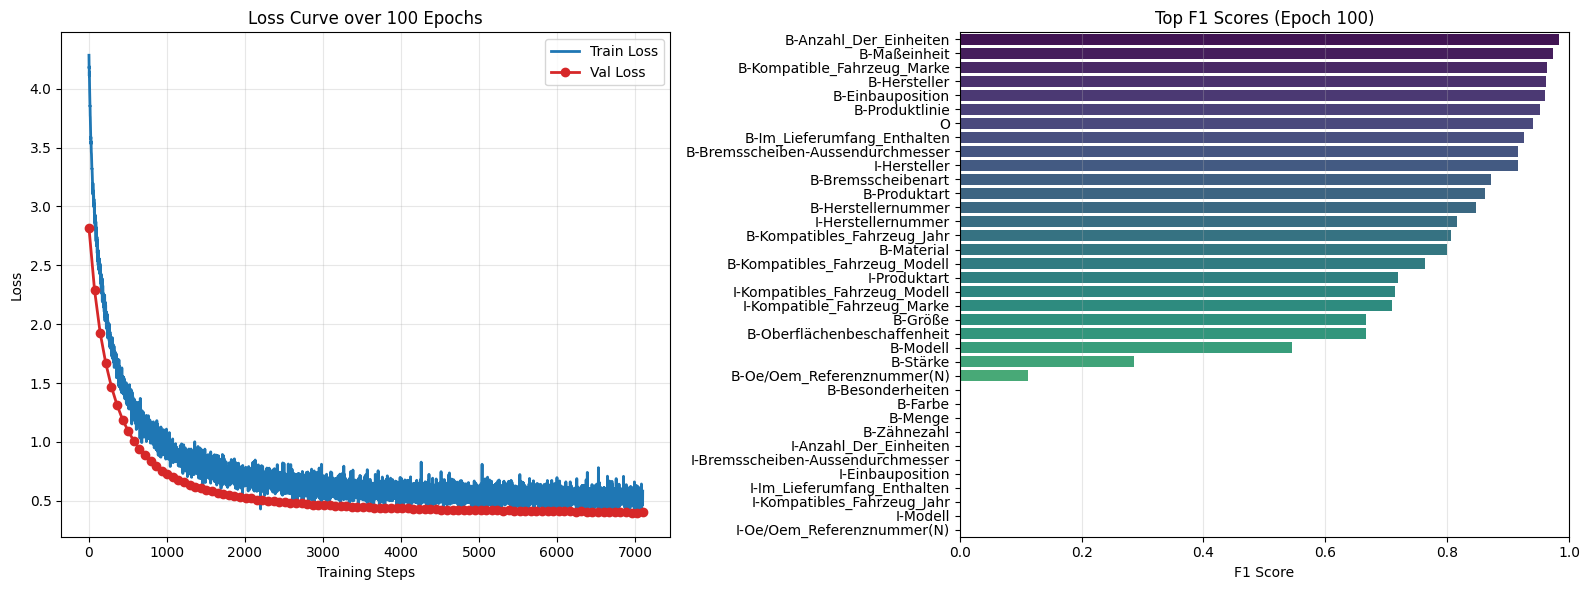

In [28]:

train_toks, val_toks, train_labs, val_labs = train_test_split(
    grouped_titles, grouped_labels, test_size=0.1, random_state=42
)
train_ds = BertDataset(train_toks, train_labs, label2id)
val_ds = BertDataset(val_toks, val_labs, label2id)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
bert_model, classifier, train_loss, val_loss, report = train_model(
    model, classifier, train_loader, val_loader, label2id, id2label
)

